# Plot model output
## Explore NetCDF output variables produced by a successful model run
This notebook is heavily inspired by https://github.com/NCAR/ctsm_python_gallery, https://mpaiao.github.io/FATES_Utils/index.html, and https://fates-users-guide.readthedocs.io/en/latest/index.html.

It is important to note that this code was written for specific versions of CLM (GitHub release tag: `ctsm5.1.dev108`) and FATES (GitHub release tag: `sci.1.58.1_api.24.1.0`), and for the specific output produced by the NorESM-LSP without customizing the underlying model code. When the CESM community updates the models, they often change or add variables, which means that you may need to update the variable names within this notebook for other versions.

**Read the instructions carefully. Unless stated otherwise, make sure to execute all code cells in sequential order.**

In this notebook you will...
1. Read in the concatenated output data
2. Explore the full data set
3. Create simple time series line plots
4. Plot variables with more dimensions
5. Understand the spin-up phase
6. Look at carbon flux outputs

Start by reading in some libraries:

In [1]:
import xarray as xr  # NetCDF data handling
import matplotlib.pyplot as plt  # Plotting
import time  # Keeping track of runtime
import json  # For reading data dictionaries stored in json format
import datetime as dt  # for workaround with long simulations (beyond year 2262)
from pathlib import Path

---
### Define names and path to the NetCDF output

**Attention! Did you concatenate your output files already? By default, the model produces many seperate output files (one per month). You should concatenate them using the [combine_nc_files.ipynb](../../notebooks/combine_nc_files.ipynb) notebook to facilitate and speed up the analysis.**

_Execute the next cell to display available case names/site IDs in the current version of the NorESM-LSP(optional)._

In [2]:
with open(Path("../../config/sites.json"), 'r', encoding='utf-8') as lsp_sites_json:
    lsp_sites_dict = json.load(lsp_sites_json)
    
print(f"{'Site code':>9}{'Long name':>25}")
print('-'*34)
_ = [print(f"{cur_site['properties']['name']:>9}{cur_site['properties']['long_name']:>25}") for cur_site in lsp_sites_dict['features']]

Site code                Long name
----------------------------------
     ALP1               Ulvehaugen
     ALP2              Laavisdalen
     ALP3               Gudmedalen
     ALP4         Skjellingahaugen
     SUB1                  Aalrust
     SUB2                 Hoegsete
     SUB3                 Rambaera
     SUB4                   Veskre
     BOR1                   Fauske
     BOR2                Vikesland
     BOR3               Arhelleren
     BOR4                Oevstedal
      ISK                  Iskoras
     HIS1              Hisaasen_up
     HIS2             Hisaasen_low
      HUR                   Hurdal
      FNS          Finse_fluxtower
      BYV                  Bayelva
      ADV              Adventdalen
      AAS                      Aas


Change the case name and site name in the code cell below before executing it.

In [3]:
# Add the full case name in quotation marks here! E.g.: "5994e825658b853b95d61feccffd18ad_bor1-1000y"
case_id = "8eee62b13ed6c7b49b39e2ba02120d9d_sub1-10years"

# Enter the case ID (aka. short site code, see table above) in quotation marks here! E.g.: "BOR1".
# ATTENTION! This is case sensitive and important to find the right paths: use the correct capitalization of letters!
site_code = "SUB1"
# If you are unsure about the site code, you can try to uncomment the next two lines instead
#import glob
#site_code = Path(glob.glob(f"../../data/{case_id}/domain*.nc")[0]).name.split("_")[2]

# Path to the case's land archive output, i.e. the folder containing the `.nc` file(s) you want to analyse. 
# Only change this line if you renamed/moved the folder or moved files from the default location!
output_data_path = Path(f"../../cases/{case_id}/archive/lnd/")

### Enter the name(s) of the output file(s) - READ CAREFULLY!

In the likely case that you produced multiple output files, we recommend to concatenate these into a single file (see above). However, if you want to combine multiple files 'on the fly', you can uncomment the respective line in the next code cell and adapt it accordingl. Note that this process can take a long time!

You can use the analysis examples in this notebook as a template for analysing additional history tapes, which you may have added in the graphical user interface when creating the case. Make sure to give the correct name (i.e. `h1`, `h2`, etc.) and that the variables you want to analyse are included in it.

Change the output file name before executing the following code cell.

In [4]:
# Enter the name of a single output file, e.g. created with the 'combine_nc_files' notebook. For example:
file_path = f"{output_data_path}/8eee62b13ed6c7b49b39e2ba02120d9d_sub1-10years.h0.0001-0010.nc"

# Optional: enter name to read in multiple output files
# The following line uses '*' wild card notation to combine all files from a given history tape on the fly
# file_path = f"{output_data_path}/hist/*h0*.nc"  # Example for reading in multiple files at once, i.e. all in the given folder for history tape zero

In [5]:
# Read data, normally no need to change
output_nc_data = xr.open_mfdataset(file_path,
                                   combine='by_coords',
                                   decode_times=True
                                  )

### Create/define folder for the case's output plots

The plots made with this notebook will be stored here.

In [6]:
# Only change if you want to use a non-default location
plot_save_path = Path().absolute() / case_id

if not plot_save_path.is_dir():
    plot_save_path.mkdir(parents=True, exist_ok=True)

### Data set exploration
There are different ways to explore your model output dataset. The code cell below prints relevant information about the NetCDF file(s) you specified above using the `xarray` package functionalities. Note that you can click in the printed information below to display more informaton. Alternatively, you can open [Panoply](http://localhost:5800/), which we include as a seperate service in the NorESM-LSP for convenience (see NorESM documentation). Panoply is ideal if you want to get a quick overview of all output variables: you can browse them in a list and easily create plots via an interactive Graphical User Interface. You simply need to navigate to your output directory at the top (by default contained in `/resources/cases/[case_id]`) to load in the data. Additional details about its full functionalities and usage instructions can be found [here](https://www.giss.nasa.gov/tools/panoply/).

In [7]:
# Print full dataset information
output_nc_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 26,
                                       fates_levcacls: 2, fates_levcapf: 4,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 2, fates_levfuel: 6,
                                       ...
                                       fates_levagepft: 14,
                                       fates_levagefuel: 42, fates_levcdsc: 26,
                                       fates_levcdpf: 52, fates_levcdam: 2,
                                       time: 120, hist_interval: 2, lndgrid: 1,
                                       fates_levelem: 1, fates_levelcwd: 4,
                                       glc_nec: 10, ltype: 9)
Coordinates: (12/15)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * fates_levcdam                     (fates_levcdam) float32 0.0 80.0
  * time                              (time) object 1901-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, fates_levcdsc, fates_levcdpf,
                                hist_interval, lndgrid, fates_levelem,
                                fates_levelcwd, glc_nec, ltype
Data variables: (12/505)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(26,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(26,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(120, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Tue Nov  8 12:41:26 2022: ncrca

If you want to learn more about the structure of NetCDF files, you may find [this introduction summary](https://adyork.github.io/python-oceanography-lesson/17-Intro-NetCDF/index.html) helpful.

---
# Create simple time series line plots
##### Plot variables with only time and lndgrid dimensions.
There are multiple ways to create output plots from xarray `DataArray` objects, i.e., for all the variables contained in the full xarray `DataSet` that we created when reading in the NetCDF files. For more details, check https://docs.xarray.dev/en/latest/user-guide/plotting.html.

Let's start by selecting one of the `Data variables` from the output above that only has `time` and `lndgrid` dimensions (listed in the parentheses in the second column when you display the data). You can switch the variable name and execute the next two code cells multiple times if you wish.

In [8]:
var_name = "FATES_VEGC_ABOVEGROUND" # "FATES_AREA_TREES", "FATES_GPP", ...

Next, explore your choice by assigning the specific variable object to a new Python variable and by printing its content.

In [9]:
var = output_nc_data[var_name]
var

<xarray.DataArray 'FATES_VEGC_ABOVEGROUND' (time: 120, lndgrid: 1)>
dask.array<open_dataset-6dbebb97f0b9891d5b73e9d59f574de8FATES_VEGC_ABOVEGROUND, shape=(120, 1), dtype=float32, chunksize=(120, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1901-02-01 00:00:00 ... 1911-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      aboveground biomass in kg carbon per m2 land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

---
The simplest way to create a plot is to use the `plot()` method that is already built into `DataArray`s. This approach is great for quick exploration, but experienced Python users may prefer the known interface and full flexibility of `matplotlib`, which we will use afterwards. The following code cell plots the variable you defined in the cells above.

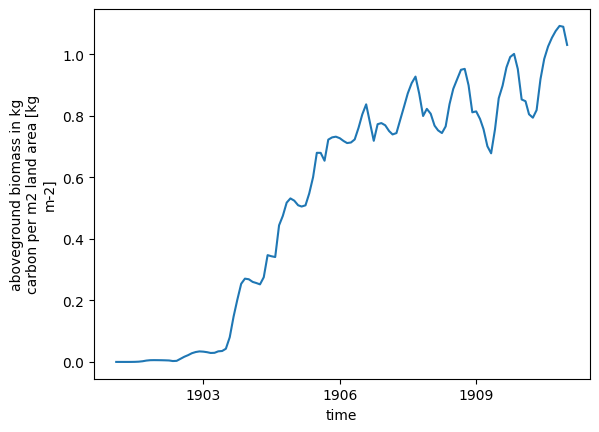

In [10]:
# Directly call the DataArray's plot method
var.plot()

As you see, this method automatically detects the internal structure of the data (2D-line plot) and assigns sensible values and labels to the axes (i.e., simulation dates and variable long name including unit). It is also possible to provide additional arguments to the function call to adapt the plot, see [the Xarray docs](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.plot.html#xarray.DataArray.plot) for details.

You can also create plots with other packages by accessing the object's values directly, e.g., with the popular `matplotlib` library. Note that the `DataArray.plot()` method also uses this library "under the hood".

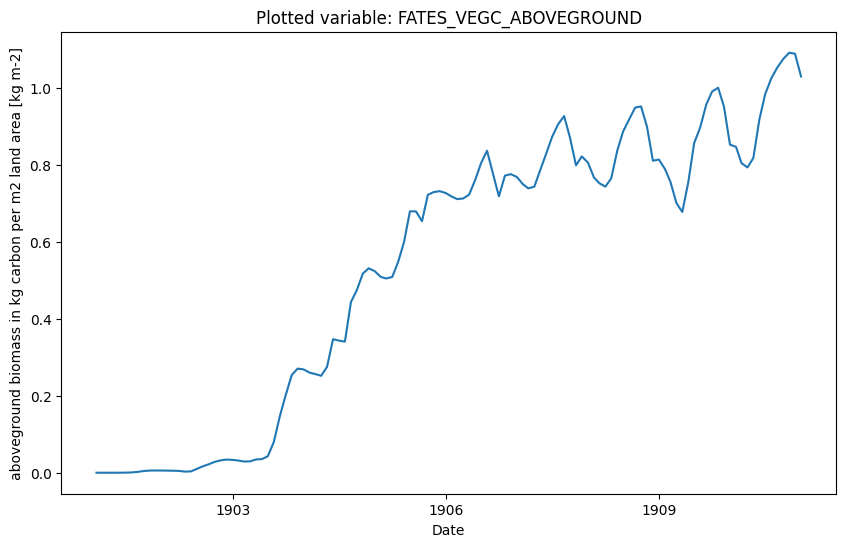

In [11]:
# Create the same plot using matplotlib library directly
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(output_nc_data['time'], var)
ax.set_title(f"Plotted variable: {var_name}")
ax.set_xlabel("Date")
ax.set_ylabel(f"{var.long_name} [{output_nc_data[var_name].units}]");

---
# Plotting variables with more dimensions
We will now create plots for a variable with more dimensions, namely `FATES_VEGC_PF`, which stores the amount of total biomass in kg of carbon per land area for each included PFT.

In [12]:
# Variable name for biomass per PFT in dataset
var_name = "FATES_VEGC_PF"

Start by again calling the internal `DataArray.plot()` method.

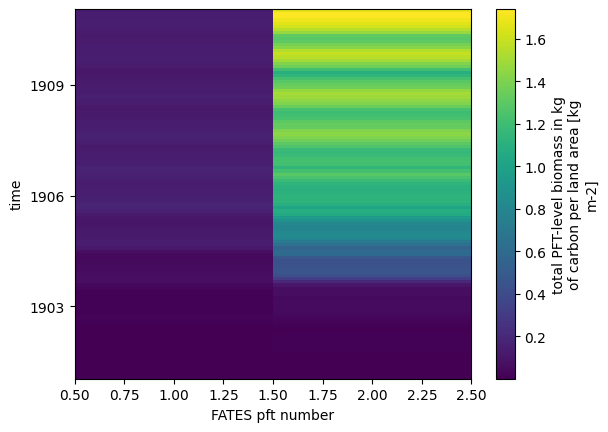

In [13]:
pft_biomass = output_nc_data[var_name]
pft_biomass.plot()

Here the default plotting method is arguably not ideal to display the output. We will hence create a customized multi-line plot and provide custom labels.

---
The following cell reads and defines some FATES PFT properties as Python `dict`(ionary) objects that we will use for plotting.

In [14]:
"""
Load and create dictionaries defining PFT and plot properties.
NB: this is version and model setting dependent!
The 'fates_pft_dict' keys are the PFT indices used in the FATES output.
"""

with open(Path("./dicts/default_fates_pfts.json"), 'r', encoding='utf-8') as fates_pft_json:
    fates_pft_dict = json.load(fates_pft_json)

pft_group_plot_dict = {
    "tree": {
        "linestyle": "-"
    },
    "shrub": {
        "linestyle": "--"
    },
    "grass": {
        "linestyle": ":"
    }
}

<h3 style="color:red;">NB! Did you use non-default PFT indices?</h3>
If you used all the PFT in your simulation, you don't need to change anything. If you changed the number of PFTs for your simulation, you need to adjust the following code. That is, you need to enter the same list of PFT indices you used when you created the case in the GUI:

1. Open the GUI window/tab (localhost:8080) and click on the site name, either using the map or the overview at the top
2. Under `Cases`, search for the case ID you are analyzing here
3. Click on ___See Variables___
4. Copy the list of integers displayed for `included_pft_indices` into the `custom_pft_indices` variable in the code cell below
5. Set the value for `use_custom_pfts` to `True`

In [15]:
# ADJUST HERE
use_custom_pfts = True  # True or False

if use_custom_pfts:
    custom_pft_indices = [  # Add the comma-seperated list of PFT indices below. OBS! Do not remove the square brackets!
        10, 11
    ]

    # NO NEED TO TOUCH THE FOLLOWING LINES #
    # Create new dict for included PFTs from default
    custom_pft_dict = {str(idx+1): fates_pft_dict[str(pft_idx)] for idx, pft_idx in enumerate(custom_pft_indices)}
    print(custom_pft_dict)

{'1': {'long_name': 'Arctic C3 grass', 'group': 'grass'}, '2': {'long_name': 'Cool C3 grass', 'group': 'grass'}}


Look at the biomass per PFT variable before making the next plot.

In [16]:
# Display variable details
pft_biomass

<xarray.DataArray 'FATES_VEGC_PF' (time: 120, fates_levpft: 2, lndgrid: 1)>
dask.array<open_dataset-6dbebb97f0b9891d5b73e9d59f574de8FATES_VEGC_PF, shape=(120, 2, 1), dtype=float32, chunksize=(120, 2, 1), chunktype=numpy.ndarray>
Coordinates:
  * fates_levpft  (fates_levpft) int32 1 2
  * time          (time) object 1901-02-01 00:00:00 ... 1911-01-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      total PFT-level biomass in kg of carbon per land area
    units:          kg m-2
    cell_methods:   time: mean
    landunit_mask:  unknown

Now let's use Matplotlib again to create a multi-line plot to depict the PFT biomass dynamics in a more tangible way. Note that you can also achieve a similar result with the built-in `DataArray.plot()` method by providing additional arguments.

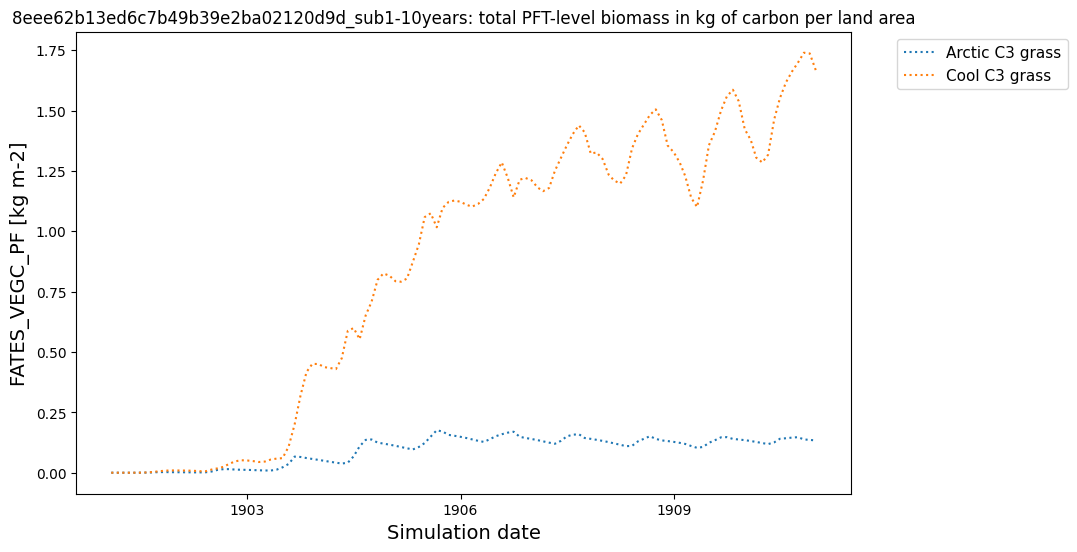

In [17]:
# Instantiate plot
fig, ax = plt.subplots(figsize=(10,6))

# Create a multi-line plot by looping through PFT properties
plot_handle_list = []

# Determine whether default or customized PFTs were used based on boolean variable
pft_dict = custom_pft_dict if use_custom_pfts else fates_pft_dict

for cur_pft_idx in pft_biomass.fates_levpft:
    
    cur_pft_dict = pft_dict[str(int(cur_pft_idx))]
    
    # Plot biomass for current PFT index
    cur_plot_handles, = ax.plot(output_nc_data['time'],
                                pft_biomass.sel(fates_levpft=cur_pft_idx),
                                label=cur_pft_dict["long_name"],
                                linestyle=pft_group_plot_dict[cur_pft_dict["group"]]["linestyle"],
                                linewidth=1.5
                               )
    
    plot_handle_list.append(cur_plot_handles)

# Set overall plot layout
ax.set_title(f"{case_id}: {pft_biomass.long_name}")
ax.set_xlabel("Simulation date", fontsize=14)
ax.set_ylabel(f"{var_name} [{pft_biomass.units}]", fontsize=14)

ax.legend(
    handles=plot_handle_list,
    bbox_to_anchor=(1.05, 1),  # Places the legend outside to the plotting area
    loc='upper left',
    fontsize=11
);

Note that this plot shows the **total PFT-level biomass**, ergo the sum of the above- and belowground biomasses of all respective PFT cohorts across all simulated patches, scaled to kg/m².

---
# `runtype = startup` - the simulation spin-up period

After we have learned how to read the data and how to create output plots while taking the differences in variable dimensions into account, we now want to focus on explaining what we see. One notorious challenge when using earth system models is the computationally expensive **spin-up phase**. When choosing `runtype=startup` in the model settings, which is the NorESM-LSP default, we start the model from a so-called "bare ground" state: the simulation commences from bare soil without any vegetation and empty carbon pools (soil, litter, etc.). In the beginning, fast-growing pioneer PFTs like grasses or fast-growing trees may thrive, before they are outcompeted by other plants or die if the climate is unsuitable. Consequently, model results that did not undergo a sufficiently long spin-up period should usually be considered invalid.

The spin-up period computational load can be maneageable for single-site simulations, but it gets more difficult the larger the simulated area is and the more model components you include. In CLM-FATES, the starting conditions are chiefly controlled by the `runtype` parameter - depending on its value, additional files and parameter changes may be required. For example, it is also possible to use a previous spin-up simulation as a starting point for other modelling experiments, which is currently not implemented in the NorESM-LSP's GUI.

Let's create plots to investigate some important state variables over our chosen simulation period.

_The following plots are inspired by the CTSM analysis tool mentioned [here](https://escomp.github.io/ctsm-docs/versions/release-clm5.0/html/users_guide/running-special-cases/Spinning-up-the-biogeochemistry-BGC-spinup.html)._

In [18]:
# Use this cell to explore the variables defined below, if you want. E.g.:
# output_nc_data["TWS"]

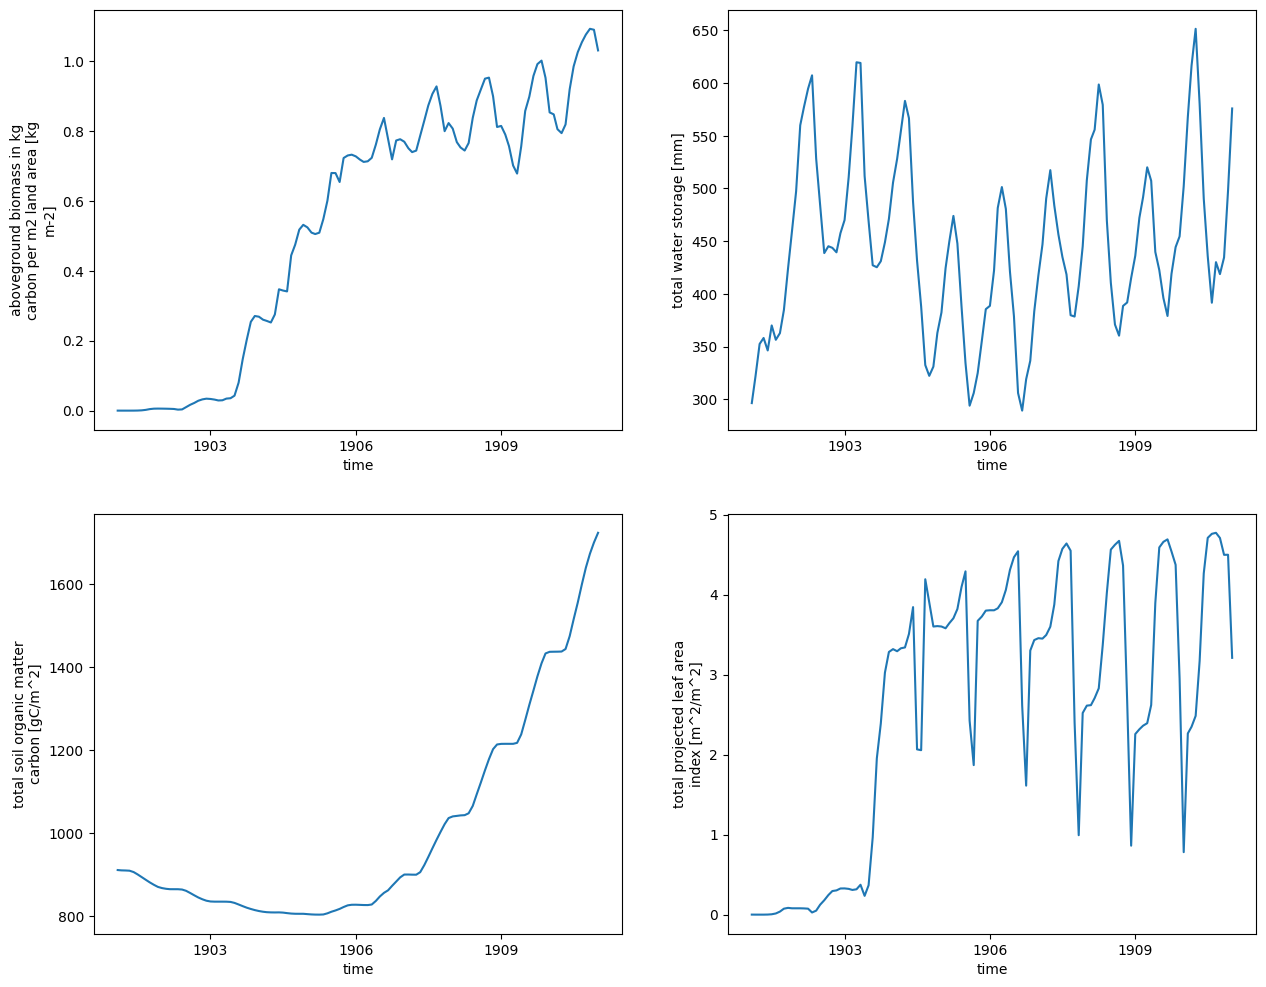

In [19]:
import math

# Variables to plot from 'output_nc_data', feel free to add more names to the list
var_names = ["FATES_VEGC_ABOVEGROUND", "TWS", "TOTSOMC", "TLAI"]

# Instantiate figure with subplot grid adapted to number of variables provided
fig, axes = plt.subplots(
    nrows=math.ceil(len(var_names)/2),
    ncols=2,
    figsize=(15, math.ceil(len(var_names)/2)*6)
)

# Delete empty axis object if number of variable names in list is odd
if len(axes.flatten()) != len(var_names):
    if len(axes.flatten()) == 2:
        fig.delaxes(axes[-1])
    else:
        fig.delaxes(axes[-1, -1])

# Plot all variables
for ax, var in zip(axes.flatten(), var_names):
    output_nc_data[var].plot(ax=ax)

If you used `runtype=startup` for your simulation, you should see that the values in the plots above start at a somewhat arbitrary value, fluctuate with the seasons, and commonly start increasing over several years. For sufficiently long periods they should stabilize over time: the vegetation and carbon pools reach an equilibrium state. The variables still fluctuate at equilibrium, driven by model processes such as disturbances and plant mortality, and by climatic variability in the forcing data, but the magnitudes and "overall patterns" do not change drastically anymore. Some state variables such as the soil carbon pool can take particularly long until they reach equilibrium due to the slow nature of the involved processes (decomposition, litter buildup, etc.). Reaching a steady state may take a long time, from hundreds to thousands of simulation years, especially in cold or dry climates where vegetation growth is slow.

---
# Carbon fluxes

A classic application for DGVMs is to investigate climate-vegetation interactions with respect to plants' crucial role in the carbon cycle. Accordingly, there are many ways to analyze how carbon "moves" between the different components of the models, for instance between the land surface and atmosphere. Let's explore some total annual C fluxes in the single-site simulation over time, summed across PFTs and patches.

In [20]:
# Display data again to investigate variables related to C fluxes
output_nc_data

<xarray.Dataset>
Dimensions:                           (levgrnd: 25, levsoi: 20, levlak: 10,
                                       levdcmp: 25, fates_levscls: 13,
                                       fates_levscag: 91, fates_levscpf: 26,
                                       fates_levcacls: 2, fates_levcapf: 4,
                                       fates_levage: 7, fates_levheight: 6,
                                       fates_levpft: 2, fates_levfuel: 6,
                                       ...
                                       fates_levagepft: 14,
                                       fates_levagefuel: 42, fates_levcdsc: 26,
                                       fates_levcdpf: 52, fates_levcdam: 2,
                                       time: 120, hist_interval: 2, lndgrid: 1,
                                       fates_levelem: 1, fates_levelcwd: 4,
                                       glc_nec: 10, ltype: 9)
Coordinates: (12/15)
  * levgrnd                           (levgrnd) float32 0.01 0.04 ... 28.87 42.0
  * levsoi                            (levsoi) float32 0.01 0.04 ... 6.94 8.03
  * levlak                            (levlak) float32 0.05 0.6 ... 34.33 44.78
  * levdcmp                           (levdcmp) float32 0.01 0.04 ... 28.87 42.0
  * fates_levscls                     (fates_levscls) float32 0.0 5.0 ... 100.0
  * fates_levcacls                    (fates_levcacls) float32 0.0 5.0
    ...                                ...
  * fates_levfuel                     (fates_levfuel) int32 1 2 3 4 5 6
  * fates_levcwdsc                    (fates_levcwdsc) int32 1 2 3 4
  * fates_levcan                      (fates_levcan) int32 1 2
  * fates_levleaf                     (fates_levleaf) int32 1 2 3 4 ... 28 29 30
  * fates_levcdam                     (fates_levcdam) float32 0.0 80.0
  * time                              (time) object 1901-02-01 00:00:00 ... 1...
Dimensions without coordinates: fates_levscag, fates_levscpf, fates_levcapf,
                                fates_levcnlf, fates_levcnlfpf,
                                fates_levscagpf, fates_levagepft,
                                fates_levagefuel, fates_levcdsc, fates_levcdpf,
                                hist_interval, lndgrid, fates_levelem,
                                fates_levelcwd, glc_nec, ltype
Data variables: (12/505)
    fates_scmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_agmap_levscag               (fates_levscag) int32 dask.array<chunksize=(91,), meta=np.ndarray>
    fates_pftmap_levscpf              (fates_levscpf) int32 dask.array<chunksize=(26,), meta=np.ndarray>
    fates_scmap_levscpf               (fates_levscpf) int32 dask.array<chunksize=(26,), meta=np.ndarray>
    fates_pftmap_levcapf              (fates_levcapf) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    fates_camap_levcapf               (fates_levcapf) int32 dask.array<chunksize=(4,), meta=np.ndarray>
    ...                                ...
    WTGQ                              (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    W_SCALAR                          (time, levsoi, lndgrid) float32 dask.array<chunksize=(120, 20, 1), meta=np.ndarray>
    ZBOT                              (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    ZWT                               (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    ZWT_CH4_UNSAT                     (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
    ZWT_PERCH                         (time, lndgrid) float32 dask.array<chunksize=(120, 1), meta=np.ndarray>
Attributes: (12/36)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              Tue Nov  8 12:41:26 2022: ncrca

Choose which variables to plot:

In [21]:
# Names of the variables that represent important C fluxes
# It is possible to add new variable names to the list (plots will be added automatically)
c_flux_var_names = ["FATES_VEGC_ABOVEGROUND", "FATES_NPP", "FATES_NEP", "FATES_GPP", "CH4PROD", "FATES_AUTORESP"]
c_flux_vars = [output_nc_data[s] for s in c_flux_var_names]

Create plots:

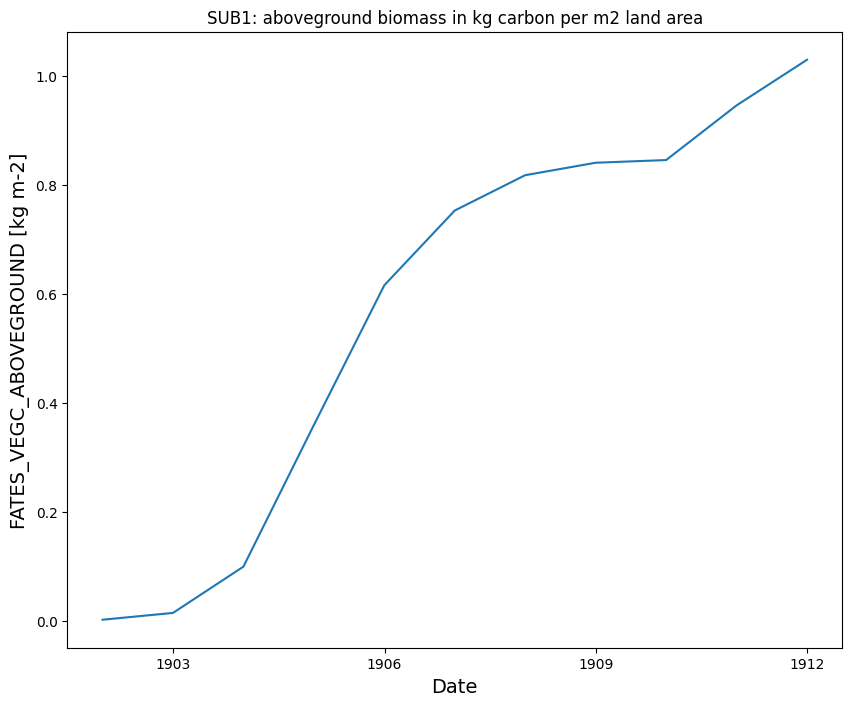

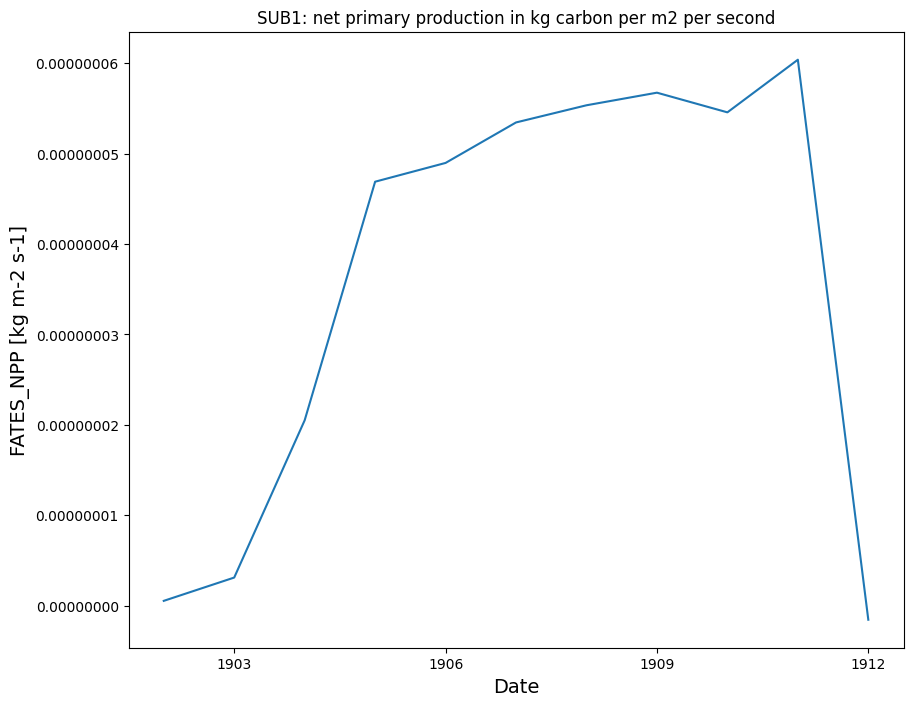

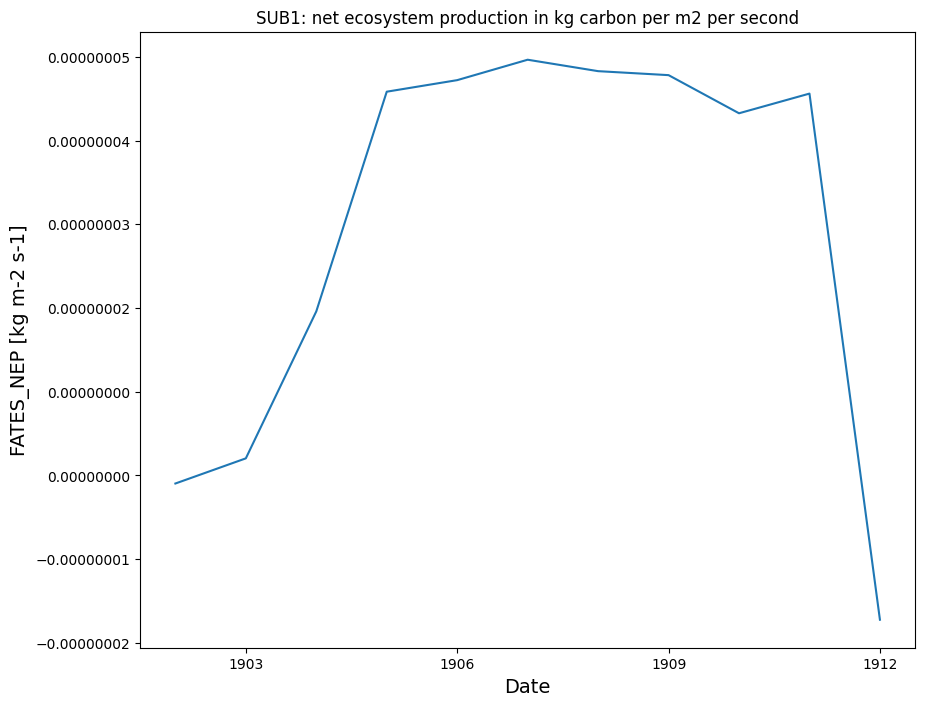

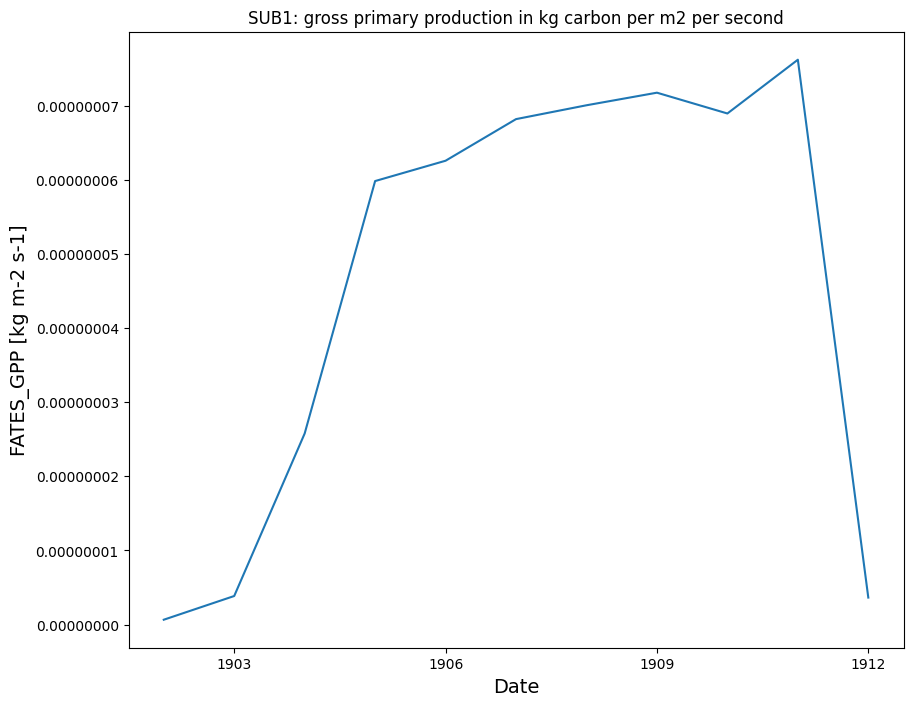

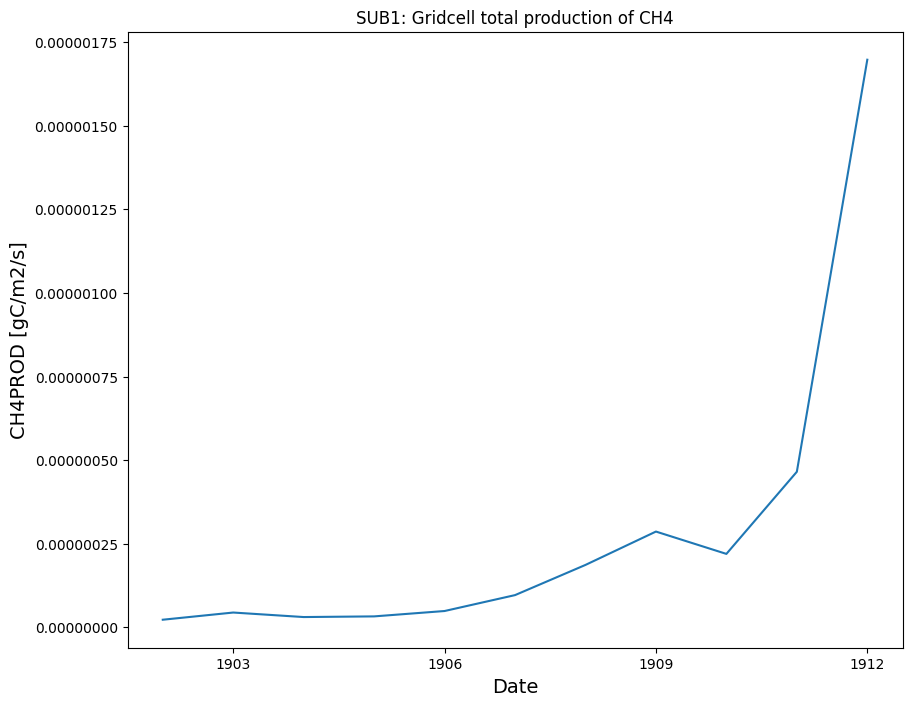

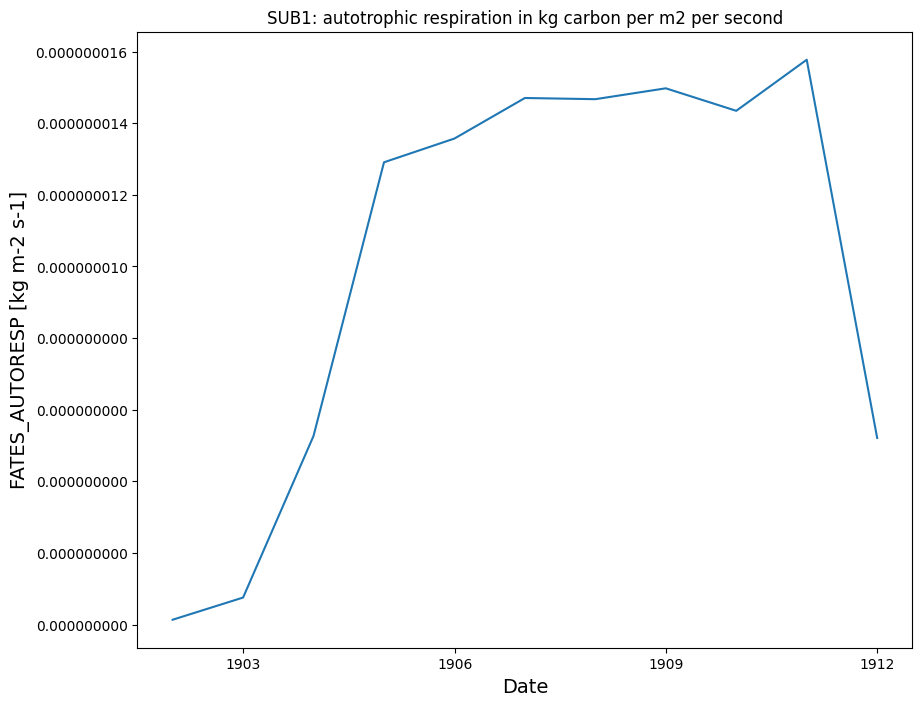

In [22]:
for c_var in c_flux_vars:
    fig, ax = plt.subplots(figsize=(10,8))
    
    c_var_annual = c_var.resample(time='1Y').mean()
    
    #cur_plot_handle, = \
    ax.plot(c_var_annual['time'], c_var_annual, label=c_var.long_name.capitalize())

    ax.set_title(f"{site_code}: {c_var.long_name}")
    ax.set_xlabel("Date", fontsize=14)
    ax.set_ylabel(f"{c_var.name} [{c_var.units}]", fontsize=14)
    
    # Use plain notation, i.e., avoid scientific "1e-3" notation
    ax.ticklabel_format(style='plain', axis='y')